# 基于历史指标预测股票涨跌幅

## Baseline-v1.0 版

Tip:这是一个最初始baseline版本,基于股票历史的收盘价、最高价、最低价、开盘价、前收盘、换手率、成交量、成交金额、总市值、流通市值预测股票的涨跌幅。

**数据：网易财经**
**股票：盛新锂能**

地址：http://quotes.money.163.com/trade/lsjysj_002240.html?year=2021&season=3

### Step 1:导入函数工具箱

In [88]:
## 基础工具
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn
from IPython.display import display, clear_output
import time

warnings.filterwarnings('ignore')
%matplotlib inline

## 模型预测的
import lightgbm as lgb
import xgboost as xgb
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

## 数据降维处理的
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA


## 参数搜索和评价的
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Step 2:数据读取

In [89]:
## 通过Pandas对于数据进行读取 

data = pd.read_csv('002240.csv',encoding='gbk')
data = data.drop(['股票代码','名称'],axis=1)
data = data.drop(data[(data.涨跌额 == "None") | (data.次日涨跌幅 == "None")].index)

data['涨跌额'] = data['涨跌额'].astype('float')
data['涨跌幅'] = data['涨跌幅'].astype('float')
data['次日涨跌幅'] = data['次日涨跌幅'].astype('float')
Train_data = data[100:]
TestA_data = data[0:100]
test_result = TestA_data.copy()
TestA_data = TestA_data.drop(['次日涨跌幅'],axis=1)


## 输出数据的大小信息
print('Train data shape:',Train_data.shape)
print('TestA data shape:',TestA_data.shape)

Train data shape: (2800, 14)
TestA data shape: (100, 13)


#### 1) 数据简要浏览

In [90]:
## 通过.head() 简要浏览读取数据的形式
Train_data.head()

,日期,收盘价,最高价,最低价,开盘价,前收盘,换手率,成交量,成交金额,总市值,流通市值,涨跌额,涨跌幅,次日涨跌幅
100,2021/3/11,20.80,21.09,19.80,20.40,20.14,3.4987,24363876,503196771.2,15593948406,1.448466e+10,0.66,3.2771,-0.9135
101,2021/3/10,20.14,20.97,20.00,20.88,20.07,2.9480,20528948,420917513.5,15099140428,1.402505e+10,0.07,0.3488,3.2771
102,2021/3/9,20.07,20.95,19.52,20.10,19.90,4.1146,28653351,580967881.6,15046660794,1.397630e+10,0.17,0.8543,0.3488
103,2021/3/8,19.90,21.71,19.90,21.50,21.52,3.6150,25174371,521641239.8,14919210254,1.385792e+10,-1.62,-7.5279,0.8543
104,2021/3/5,21.52,22.15,20.96,21.01,21.80,3.0580,21295470,461293384.0,16133738928,1.498605e+10,-0.28,-1.2844,-7.5279


#### 2) 数据信息查看

In [91]:
## 通过 .info() 简要可以看到对应一些数据列名，以及NAN缺失信息
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2900 entries, 0 to 3213
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   日期      2900 non-null   object 
 1   收盘价     2900 non-null   float64
 2   最高价     2900 non-null   float64
 3   最低价     2900 non-null   float64
 4   开盘价     2900 non-null   float64
 5   前收盘     2900 non-null   float64
 6   换手率     2900 non-null   float64
 7   成交量     2900 non-null   int64  
 8   成交金额    2900 non-null   float64
 9   总市值     2900 non-null   int64  
 10  流通市值    2900 non-null   float64
 11  涨跌额     2900 non-null   float64
 12  涨跌幅     2900 non-null   float64
 13  次日涨跌幅   2899 non-null   float64
dtypes: float64(11), int64(2), object(1)
memory usage: 339.8+ KB


In [92]:
## 通过 .columns 查看列名
Train_data.columns

Index(['日期', '收盘价', '最高价', '最低价', '开盘价', '前收盘', '换手率', '成交量', '成交金额', '总市值',
       '流通市值', '涨跌额', '涨跌幅', '次日涨跌幅'],
      dtype='object')

In [93]:
TestA_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   日期      100 non-null    object 
 1   收盘价     100 non-null    float64
 2   最高价     100 non-null    float64
 3   最低价     100 non-null    float64
 4   开盘价     100 non-null    float64
 5   前收盘     100 non-null    float64
 6   换手率     100 non-null    float64
 7   成交量     100 non-null    int64  
 8   成交金额    100 non-null    float64
 9   总市值     100 non-null    int64  
 10  流通市值    100 non-null    float64
 11  涨跌额     100 non-null    float64
 12  涨跌幅     100 non-null    float64
dtypes: float64(10), int64(2), object(1)
memory usage: 10.9+ KB


#### 3) 数据统计信息浏览

In [94]:
## 通过 .describe() 可以查看数值特征列的一些统计信息
data.describe()

,收盘价,最高价,最低价,开盘价,前收盘,换手率,成交量,成交金额,总市值,流通市值,涨跌额,涨跌幅,次日涨跌幅
count,2900.000000,2900.000000,2900.000000,2900.000000,2900.000000,2900.000000,2.900000e+03,2.900000e+03,2.900000e+03,2.900000e+03,2900.000000,2900.000000,2899.000000
mean,12.260531,12.561666,11.950262,12.232810,12.250569,3.460512,1.319820e+07,2.133017e+08,6.302168e+09,5.426801e+09,0.009962,0.102371,0.100211
std,6.650873,6.880214,6.408590,6.617835,6.628564,3.326979,1.497529e+07,3.889688e+08,4.838911e+09,4.834354e+09,0.552117,3.489053,3.425859
min,3.570000,3.610000,3.480000,3.530000,3.570000,0.056400,2.766200e+05,1.936340e+06,1.542651e+09,3.857507e+08,-4.440000,-10.035000,-10.035000
25%,8.090000,8.280000,7.900000,8.050000,8.080000,1.238075,3.829560e+06,3.306440e+07,3.038838e+09,1.830326e+09,-0.160000,-1.565325,-1.554550
50%,10.770000,10.955000,10.520000,10.710000,10.765000,2.486600,7.423458e+06,7.307249e+07,4.882505e+09,4.283846e+09,0.010000,0.138150,0.139300
75%,14.685000,14.990000,14.335000,14.672500,14.685000,4.622175,1.631157e+07,2.148071e+08,7.966691e+09,7.147104e+09,0.180000,1.794175,1.795750
max,51.200000,53.130000,49.840000,50.250000,51.200000,70.074400,1.319941e+08,4.423091e+09,3.838510e+10,3.565455e+10,4.740000,30.191100,10.095200


In [95]:
TestA_data.describe()

,收盘价,最高价,最低价,开盘价,前收盘,换手率,成交量,成交金额,总市值,流通市值,涨跌额,涨跌幅
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,100.000000,100.000000
mean,30.088100,31.099600,28.918200,29.816500,29.872300,6.039612,4.205853e+07,1.370580e+09,2.275169e+10,2.095269e+10,0.215800,0.815656
std,8.858219,9.442081,8.296731,8.825543,8.818516,2.617850,1.823010e+07,9.241444e+08,6.975966e+09,6.168668e+09,1.520926,4.537579
min,19.380000,20.280000,19.300000,19.480000,19.380000,2.074300,1.444507e+07,2.938891e+08,1.452936e+10,1.349580e+10,-4.440000,-10.011000
25%,22.735000,22.960000,21.812500,22.132500,22.367500,4.039925,2.813332e+07,7.083990e+08,1.704464e+10,1.583215e+10,-0.345000,-1.261150
50%,28.360000,29.095000,27.650000,28.050000,28.260000,5.389400,3.753064e+07,1.066955e+09,2.126175e+10,1.974928e+10,0.140000,0.453350
75%,32.617500,33.580000,30.825000,32.382500,32.320000,7.594775,5.288839e+07,1.855273e+09,2.445364e+10,2.271411e+10,0.952500,3.300625
max,51.200000,53.130000,49.840000,50.250000,51.200000,13.893700,9.675249e+07,4.423091e+09,3.838510e+10,3.565455e+10,4.500000,10.013000


In [96]:
# import pandas_profiling

# pfr = pandas_profiling.ProfileReport(data)
# pfr.to_file("./example.html")

### Step 3:特征与标签构建

#### 1) 提取数值类型和类别特征列名

In [97]:
numerical_cols = Train_data.select_dtypes(exclude = 'object').columns
print(numerical_cols)
categorical_cols = Train_data.select_dtypes(include = 'object').columns
print(categorical_cols)

Index(['收盘价', '最高价', '最低价', '开盘价', '前收盘', '换手率', '成交量', '成交金额', '总市值', '流通市值',
       '涨跌额', '涨跌幅', '次日涨跌幅'],
      dtype='object')
Index(['日期'], dtype='object')


#### 2) 构建训练和测试样本

In [98]:
## 选择特征列
# feature_cols = [col for col in numerical_cols if col not in ['SaleID','name','regDate','creatDate','price','model','brand','regionCode','seller']]
# feature_cols = [col for col in feature_cols if 'Type' not in col]

# feature_cols = ['日期','收盘价', '最高价', '最低价', '开盘价', '前收盘', '换手率', '成交量', '成交金额', '总市值', '流通市值',
#        '涨跌额', '涨跌幅']

feature_cols = ['收盘价', '最高价', '最低价', '开盘价', '前收盘', '换手率', '成交量', '成交金额', '总市值', '流通市值',
       '涨跌额', '涨跌幅']

## 提前特征列，标签列构造训练样本和测试样本
X_data = Train_data[feature_cols]
Y_data = Train_data['次日涨跌幅']

X_test  = TestA_data[feature_cols]

print('X train shape:',X_data.shape)
print('X test shape:',X_test.shape)

X train shape: (2800, 12)
X test shape: (100, 12)


In [99]:
## 定义了一个统计函数，方便后续信息统计
def Sta_inf(data):
    print('_min',np.min(data))
    print('_max:',np.max(data))
    print('_mean',np.mean(data))
    print('_ptp',np.ptp(data))
    print('_std',np.std(data))
    print('_var',np.var(data))

#### 3) 统计标签的基本分布信息

In [100]:
print('Sta of label:')
Sta_inf(Y_data)


Sta of label:
_min -10.035
_max: 10.0952
_mean 0.07429764285714266
_ptp 20.130200000000002
_std 3.3764940060599424
_var 11.400711772958719


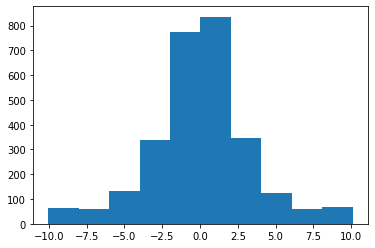

In [101]:
## 绘制标签的统计图，查看标签分布
plt.hist(Y_data)
plt.show()
plt.close()


#### 4) 缺省值用-1填补

In [102]:
X_data = X_data.fillna(-1)
X_test = X_test.fillna(-1)

### Step 4:模型训练与预测

#### 1) 利用xgb进行五折交叉验证查看模型的参数效果

In [103]:
# ## xgb-Model
# xgr = xgb.XGBRegressor(n_estimators=120, learning_rate=0.1, gamma=0, subsample=0.8,\
#         colsample_bytree=0.9, max_depth=7) #,objective ='reg:squarederror'

# scores_train = []
# scores = []

# ## 5折交叉验证方式
# sk=StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
# print(X_data.dtypes)
# print(Y_data.dtypes)
# for train_ind,val_ind in sk.split(X_data,Y_data):
    
#     train_x=X_data.iloc[train_ind].values
#     train_y=Y_data.iloc[train_ind]
#     val_x=X_data.iloc[val_ind].values
#     val_y=Y_data.iloc[val_ind]
    
#     xgr.fit(train_x,train_y)
#     pred_train_xgb=xgr.predict(train_x)
#     pred_xgb=xgr.predict(val_x)
    
#     score_train = mean_absolute_error(train_y,pred_train_xgb)
#     scores_train.append(score_train)
#     score = mean_absolute_error(val_y,pred_xgb)
#     scores.append(score)

# print('Train mae:',np.mean(score_train))
# print('Val mae',np.mean(scores))

#### 2） 定义xgb和lgb模型函数

In [104]:
def build_model_xgb(x_train,y_train):
    model = xgb.XGBRegressor(n_estimators=150, learning_rate=0.1, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=7) #, objective ='reg:squarederror'
    model.fit(x_train, y_train)
    return model

def build_model_lgb(x_train,y_train):
    estimator = lgb.LGBMRegressor(num_leaves=127,n_estimators = 150)
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
    }
    gbm = GridSearchCV(estimator, param_grid)
    gbm.fit(x_train, y_train)
    return gbm

#### 3）切分数据集（Train,Val）进行模型训练，评价和预测

In [105]:
## Split data with val
x_train,x_val,y_train,y_val = train_test_split(X_data,Y_data,test_size=0.3)

In [108]:
print('Train lgb...')
model_lgb = build_model_lgb(x_train,y_train)
val_lgb = model_lgb.predict(x_val)
MAE_lgb = mean_absolute_error(y_val,val_lgb)
print('MAE of val with lgb:',MAE_lgb)

print('Predict lgb...')
model_lgb_pre = build_model_lgb(X_data,Y_data)
subA_lgb = model_lgb_pre.predict(X_test)
print('Sta of Predict lgb:')
Sta_inf(subA_lgb)



Train lgb...
MAE of val with lgb: 2.449085229357331
Predict lgb...
Sta of Predict lgb:
_min -2.723364200977184
_max: 2.2046808851243536
_mean -1.208441951835868
_ptp 4.9280450861015375
_std 1.3892499041867548
_var 1.9300152962829071


In [109]:
print('Train xgb...')
model_xgb = build_model_xgb(x_train,y_train)
val_xgb = model_xgb.predict(x_val)
MAE_xgb = mean_absolute_error(y_val,val_xgb)
print('MAE of val with xgb:',MAE_xgb)

print('Predict xgb...')
model_xgb_pre = build_model_xgb(X_data,Y_data)
subA_xgb = model_xgb_pre.predict(X_test)
print('Sta of Predict xgb:')
Sta_inf(subA_xgb)

test_result['预测涨跌幅'] = subA_xgb
test_result.to_csv('./result.csv',encoding='gbk')

Train xgb...
MAE of val with xgb: 2.6124433991237463
Predict xgb...
Sta of Predict xgb:
_min -7.738511
_max: 5.4021134
_mean -1.4871407
_ptp 13.140625
_std 2.6406853
_var 6.973219


#### 4）进行两模型的结果加权融合

In [84]:
## 这里我们采取了简单的加权融合的方式
val_Weighted = (1-MAE_lgb/(MAE_xgb+MAE_lgb))*val_lgb+(1-MAE_xgb/(MAE_xgb+MAE_lgb))*val_xgb
val_Weighted[val_Weighted<0]=10 # 由于我们发现预测的最小值有负数，而真实情况下，price为负是不存在的，由此我们进行对应的后修正
print('MAE of val with Weighted ensemble:',mean_absolute_error(y_val,val_Weighted))

MAE of val with Weighted ensemble: 6.02636627420805


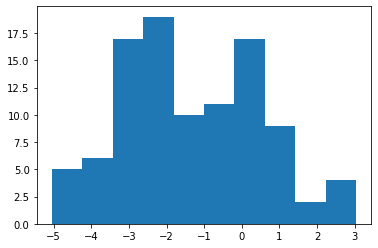

In [85]:
sub_Weighted = (1-MAE_lgb/(MAE_xgb+MAE_lgb))*subA_lgb+(1-MAE_xgb/(MAE_xgb+MAE_lgb))*subA_xgb

## 查看预测值的统计情况
plt.hist(sub_Weighted)
plt.show()
plt.close()

#### 5）输出结果

In [40]:
sub = pd.DataFrame()
sub['SaleID'] = TestA_data.SaleID
sub['price'] = sub_Weighted
sub.to_csv('./sub_Weighted.csv',index=False)

In [41]:
sub.head()

,SaleID,price
0,200000,1177.411350
1,200001,1806.533808
2,200002,8560.360662
3,200003,1346.399612
4,200004,2074.420147
